In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

# Keeping your diagram's DRY

In this tutorial, we will look at some design patterns that can keep your workflow logic composable and DRY.

In [ ]:
from stringdale import Define,V,E,Scope,Condition
from stringdale.chat import Chat

## Changing nodes when instantiating diagrams

Imagine we would like to write a diagram that queries a database for info.

In [ ]:
from stringdale.db import temp_sql_db
from sqlmodel import SQLModel, Session, select, Field
from typing import Optional

In [ ]:
engine = temp_sql_db()

In [ ]:
#| hide
# used for restarting the db
SQLModel.metadata.clear()

In [ ]:
class User(SQLModel, table=True,extend_existing=True):
    id: int = Field(default=None, primary_key=True)
    name: Optional[str] = Field(default=None)
    age: Optional[int] = Field(default=None)
    email: Optional[str] = Field(default=None)

# Loads the schema of all SQLModel subclasses into the db
SQLModel.metadata.create_all(engine)

In [ ]:
with Session(engine) as session:
    user1 = User(name="Alice Smith", age=28, email="alice@example.com")
    user2 = User(name="Bob Jones", age=35, email="bob@example.com")
    session.merge(user1)
    session.merge(user2)
    session.commit()

For example we would like to do something with the total age of users in our database.

During prototyping, you might end up with something like this:

In [ ]:
from sqlalchemy import text

In [ ]:
def total_age_query(session):
    return session.execute(text("SELECT SUM(age) FROM user")).scalar()
    

In [ ]:
with Session(engine) as session:
    res = total_age_query(session)
res

63

In [ ]:
def total_age_devdb():
    global engine
    with Session(engine) as session:
        return total_age_query(session)

total_age_devdb()

63

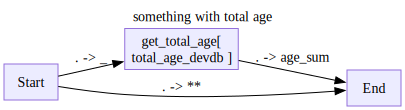

In [ ]:
with Define('something with total age') as D:
    V('get_total_age',total_age_devdb,
        inputs=['Start(_)'],
        outputs=['End(age_sum=.)']
    )
    E('Start->End(**)')
D.draw()

However, when we want to run it in production, we would like to connect it to a session of our production DB.

Does it mean we need to rewrite our diagram schema? Not quite.

We can instead, override the node's function with a new one during instantiation.

In [ ]:
from functools import partial

In [ ]:
# imagine that this is a production engine
production_engine = engine

with Session(production_engine) as session:
    # we make a function that uses our session
    total_age_prod = partial(total_age_query,session=session)
    # and override the node's function using the kwargs of the diagram instantiation
    d = D(get_total_age=total_age_prod)

    for trace in d.run({'a':1}):
        pass

d.output

{'a': 1, 'age_sum': 63}

To recap:

* We build our core logic to accept our external resources as parameters.
* We can develop our diagram on dev resources
* We can override function of specific instances to change resources.
    * ie, moving to a production DB, or running the same diagram on different DBs

## Diagram Factories - Making user QA dry

Often, we would like to reuse workflows with slight modifications to the wiring of nodes. Ones we could not accomplish easily with overriding of node logic.

For example, recall our user QA diagram

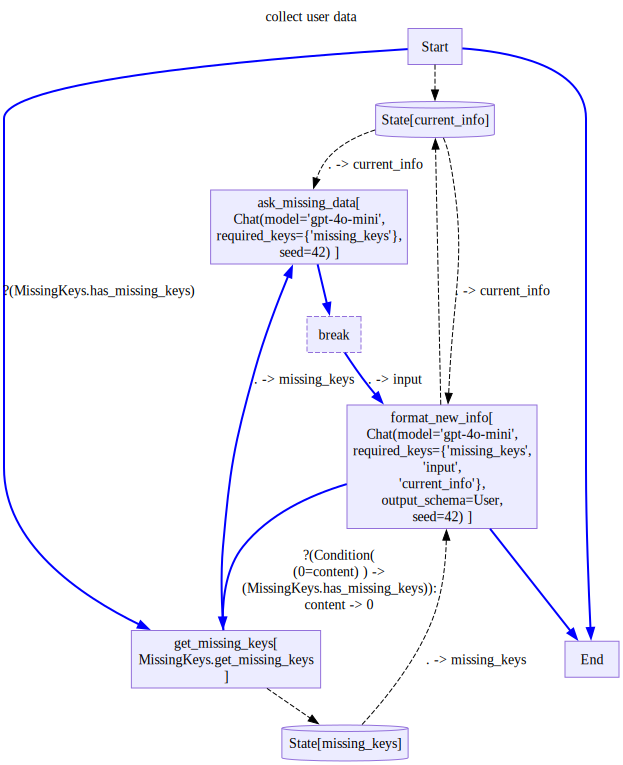

In [ ]:
ask_missing_data = Chat(
    model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
        You are a helpful assistant asks the user for missing information.
        Do not ask for keys if they are not a part of the missing keys
        Ask the user for the following missing keys:
        {{missing_keys}}
        '''}])

format_new_info = Chat(
    model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
        You are a helpful assistant that gets user data and makes sure it is complete.
        If you are not sure that you were given the relevant information, put None in the relevant field.
        Fill part of the missing keys based on the user data.
        If the user didnt provide info an a given missing key, leave it empty
        
        {% if current_info %}
        The information we have so far is:
        {{current_info}}
        {% endif %}
        The missing keys are:
        {{missing_keys}}
        '''},
        {'role':'user','content':'{{input}}'},
        
    ],
    output_schema=User)

class MissingKeys():
    def __init__(self,keys):
        self.keys = keys

    def get_missing_keys(self,obj):
        return [key for key in self.keys if getattr(obj,key,None) is None]

    def has_missing_keys(self,obj):
        return len(self.get_missing_keys(obj)) > 0

missing = MissingKeys(['name','age'])

with Define('collect user data',type='decision') as UserQA:
    V('Start',
        outputs=[
            ('get_missing_keys',missing.has_missing_keys),
            ('End',),
            ('state/current_info',)
        ])

    V('get_missing_keys',missing.get_missing_keys,
        outputs=[
            'ask_missing_data(missing_keys)',
            'state/missing_keys'

        ])

    V('ask_missing_data',ask_missing_data,
        inputs=['state/current_info(current_info)'],
        outputs=['break']    )

    V('break',is_break=True,outputs=['format_new_info(input)'])

    
    V('format_new_info',format_new_info,
        inputs=[
            'state/current_info(current_info)',
            'state/missing_keys(missing_keys=.)'
        ],
        outputs=[
            ('get_missing_keys(0=content)',Condition(missing.has_missing_keys,'(0=content)')),
            'End',
            'state/current_info'
        ])

UserQA.draw(direction='TB')


What if we want to collect data from a different struct?

Or ask for different keys?

Overriding can get cumbersome really quickly.
Instead we build a diagram factory.

A diagram factory is a function that takes some parameters and returns a Diagram Schema.

```python
# define the factory
def diagram_factory(**kwargs):

    with Define(f'RAG',type='decision') as D:
        ... # define the diagram here

    # return the schema
    return D

# we can make different diagrams from the same factory
RAG1 = rag_factory(...)
RAG2 = rag_factory(...)

# and use them normally
r1 = RAG1()
for trace in r1.run({'question':'...'}):
    trace.pprint()

r2 = RAG2()
for trace in r2.run({'question':'...'}):
    trace.pprint()
```


Lets see how we can make our interactive QA DRY using the factory pattern.

In [ ]:
def InteractiveQAFactory(base_model,missing_keys):
    ask_missing_data = Chat(
    model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
        You are a helpful assistant asks the user for missing information.
        Do not ask for keys if they are not a part of the missing keys
        Ask the user for the following missing keys:
        {{missing_keys}}
        '''}])

    format_new_info = Chat(
        model='gpt-4o-mini',
        messages=[
            {'role':'system','content':'''
            You are a helpful assistant that gets user data and makes sure it is complete.
            If you are not sure that you were given the relevant information, put None in the relevant field.
            Fill part of the missing keys based on the user data.
            If the user didnt provide info an a given missing key, leave it empty
            
            {% if current_info %}
            The information we have so far is:
            {{current_info}}
            {% endif %}
            The missing keys are:
            {{missing_keys}}
            '''},
            {'role':'user','content':'{{input}}'},
            
        ],
        # we change the base model based on the param
        output_schema=base_model)

    missing = MissingKeys(missing_keys)

    with Define(f'collect {base_model.__name__} keys: {missing_keys} ',type='decision') as UserQA:
        V('Start',
            outputs=[
                ('get_missing_keys',missing.has_missing_keys),
                ('End',),
                ('state/current_info',)
            ])

        V('get_missing_keys',missing.get_missing_keys,
            outputs=[
                'ask_missing_data(missing_keys)',
                'state/missing_keys'

            ])

        V('ask_missing_data',ask_missing_data,
            inputs=['state/current_info(current_info)'],
            outputs=['break']    )

        V('break',is_break=True,outputs=['format_new_info(input)'])

        
        V('format_new_info',format_new_info,
            inputs=[
                'state/current_info(current_info)',
                'state/missing_keys(missing_keys=.)'
            ],
            outputs=[
                ('get_missing_keys(0=content)',Condition(missing.has_missing_keys,'(0=content)')),
                'End',
                'state/current_info'
            ])
    return UserQA


In [ ]:
GetEmail = InteractiveQAFactory(User,missing_keys=['id','email'])
GetNameAndAge = InteractiveQAFactory(User,missing_keys=['id','name','age'])

In [ ]:
email_d = GetEmail()
email_d.run_all(None)

{'role': 'assistant',
 'content': "Please provide the missing information: 'id' and 'email'.",
 'meta': {'input_tokens': 151, 'output_tokens': 18}}

In [ ]:
email_d.run_all('json@gmail.com, id=1')


{'role': 'assistant',
 'content': User(id=1, name=None, age=None, email='json@gmail.com'),
 'meta': {'input_tokens': 340, 'output_tokens': 30}}

In [ ]:
get_name_and_age = GetNameAndAge()
get_name_and_age.run_all(None)

{'role': 'assistant',
 'content': 'Please provide the following information: \n1. ID: \n2. Name: \n3. Age: ',
 'meta': {'input_tokens': 154, 'output_tokens': 28}}

In [ ]:
get_name_and_age.run_all('jason, 25 , id =2')

{'role': 'assistant',
 'content': User(id=2, name='jason', age=25, email=None),
 'meta': {'input_tokens': 345, 'output_tokens': 30}}

## Programmatic diagram generation - making Router Workdflow DRY

Let us recall the router agent from the compound diagrams tutorial

In [ ]:
rhyming_agent = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    Answer the following questions using rhyming words.
    """},
    {'role':'user','content':'{{question}}'},
    ],
    )

joke_agent = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    Answer the following question with a joke.
    """},
    {'role':'user','content':'{{question}}'},
    ])

yo_mama_chat = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    Answer the following question with a joke about the person's mother.
    """},
    {'role':'user','content':'{{question}}'},
    ])

choice_descriptions = {
    'rhyme':'this agent is good at rhyming',
    'joke': 'this agent is good at telling jokes',
    'yo_mama': 'this agent is specifically good at telling jokes about mothers'
}

router = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    Choose the best sub-agent to answer the following question from among the following options:
    {% for name,description in choice_descriptions.items() %}
    - {{name}}: {{description}}
    {% endfor %}
    """},
    {'role':'user','content':'{{question}}'},
    ],
    choice_descriptions = choice_descriptions,
    choices=list(choice_descriptions.keys())
    )

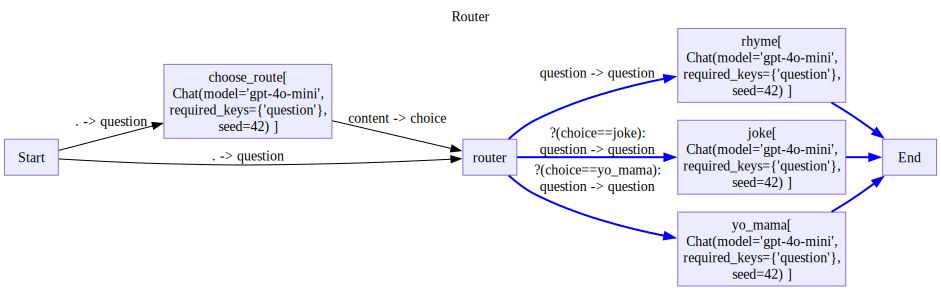

In [ ]:
with Define('Router',type='decision') as CompoundRouter:
    with Scope('flow'):
        V('choose_route',router,inputs=['Start(question=.)'])
        V('router',
            inputs=[
                'choose_route(choice=content)',
                'Start(question=.)'
                ],)

    E('router->rhyme(question=question)')
    E('router->joke(question=question)',cond=Condition('joke','(0=choice)',name='choice==joke'))
    E('router->yo_mama(question=question)',cond=Condition('yo_mama','(0=choice)',name='choice==yo_mama'))
    
    V('rhyme',rhyming_agent,outputs=['End'])
    V('joke',joke_agent,outputs=['End'])
    V('yo_mama',yo_mama_chat,outputs=['End'])

CompoundRouter.draw()

As the number of sub agents to route to increases, we have to add more code to the diagram's structure, increasing the likelihood of a bug.
In our `Define` block, we can run any python code. So we can use for loops and format strings to make our code more DRY.

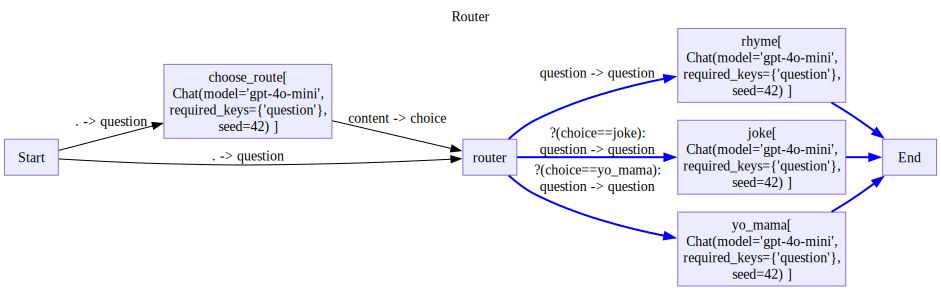

In [ ]:
with Define('Router',type='decision') as CompoundRouter:
    with Scope('flow'):
        V('choose_route',router,inputs=['Start(question=.)'])
        V('router',
            inputs=[
                'choose_route(choice=content)',
                'Start(question=.)'
                ],)

    default = 'rhyme'
    for choice,agent in {'rhyme':rhyming_agent,'joke':joke_agent,'yo_mama':yo_mama_chat}.items():
        V(choice,agent,outputs=['End'])
        if choice == default:
            E(f'router->{choice}(question=question)')
        else:
            E(f'router->{choice}(question=question)',cond=Condition(choice,'(0=choice)',name=f'choice=={choice}'))

CompoundRouter.draw()

Combining this with the factory pattern can become really powerful!

In [ ]:
from typing import Dict,Any

In [ ]:
def RouterFactory(sub_agents:Dict[str,Any],default_choice:str):

    router = Chat(model='gpt-4o-mini',
        messages=[{'role':'system','content':"""
        Choose the best sub-agent to answer the following question from among the following options:
        {% for name,description in choice_descriptions.items() %}
        - {{name}}: {{description}}
        {% endfor %}
        """},
        {'role':'user','content':'{{question}}'},
        ],
        choice_descriptions = {name:agent['description'] for name,agent in sub_agents.items()},
        choices=list(sub_agents.keys())
    )

    with Define('Router',type='decision') as CompoundRouter:
        with Scope('flow'):
            V('choose_route',router,inputs=['Start(question=.)'])
            V('router',
                inputs=[
                    'choose_route(choice=content)',
                    'Start(question=.)'
                    ],)

        default = 'rhyme'
        for choice,agent in sub_agents.items():
            agent_func = agent['func']
            V(choice,agent_func,outputs=['End'])
            if choice == default_choice:
                E(f'router->{choice}(question=question)')
            else:
                E(f'router->{choice}(question=question)',cond=Condition(choice,'(0=choice)',name=f'choice=={choice}'))
    
    return CompoundRouter


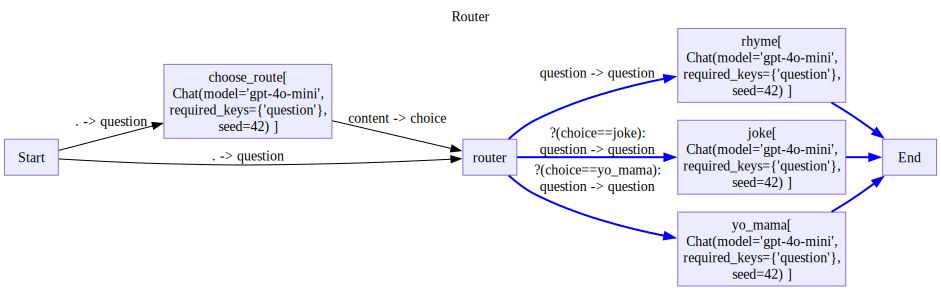

In [ ]:
sub_agents = {
    'rhyme':{
        'description':'this agent is good at rhyming',
        'func':rhyming_agent
    },
    'joke':{
        'description':'this agent is good at telling jokes',
        'func':joke_agent
    },
    'yo_mama':{
        'description':'this agent is specifically good at telling jokes about mothers',
        'func':yo_mama_chat
    }
}

Router = RouterFactory(sub_agents,'rhyme')
Router.draw()


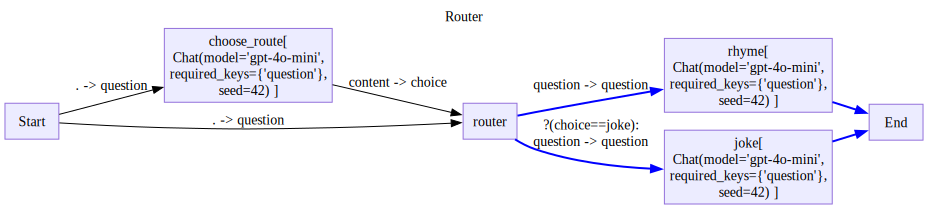

In [ ]:
sub_agents = {
    'rhyme':{
        'description':'this agent is good at rhyming',
        'func':rhyming_agent
    },
    'joke':{
        'description':'this agent is good at telling jokes',
        'func':joke_agent
    },
}

Router = RouterFactory(sub_agents,'rhyme')
Router.draw()
